# Data Collection and Acquisation

In [1]:
!pip install split-folders

In [2]:
import splitfolders

# Path to your dataset
input_folder = '/kaggle/input/alzheimers-synthesized-dataset/dataset/normal_dataset'

# Output folder
output_folder = './Dataset'

# Split the dataset (train: 80%, val: 10%, test: 10%)
splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(.8, .1, .1))

Copying files: 8000 files [01:02, 128.43 files/s]


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from keras.layers import Input,Lambda,Dense,Flatten,BatchNormalization,Dropout
from keras import Model
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
import datetime

2024-07-14 13:38:03.108679: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 13:38:03.108778: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 13:38:03.234006: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
#re-sizing all images to this size
IMAGE_SIZE = [128,128]

#training config
epochs = 200
batch_size = 32

In [5]:
train_path = './Dataset/train'
val_path = './Dataset/val'
test_path = './Dataset/test'

# useful for getting the number of files
image_files = glob(train_path + '/*/*.jp*g')
val_image_files = glob(val_path + '/*/*.jp*g')
test_image_files = glob(test_path + '/*/*.jp*g')

# useful for getting number of classes
folders = glob(train_path + '/*')
num_classes = len(folders)

In [6]:
train_gen = ImageDataGenerator(
    rescale=1./255,
#     rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


val_gen = ImageDataGenerator(
 rescale=1./255,
)

test_gen = ImageDataGenerator(
     rescale=1./255,
)

#create generator

train_generator = train_gen.flow_from_directory(
    train_path,
    target_size = IMAGE_SIZE,
    shuffle = True,
    batch_size = batch_size
)

val_generator = val_gen.flow_from_directory(
    val_path,
    target_size = IMAGE_SIZE,
    shuffle = True,
    batch_size = batch_size
)

test_generator = test_gen.flow_from_directory(
    test_path,
    target_size = IMAGE_SIZE,
    shuffle = True,
    batch_size = batch_size
)

Found 6400 images belonging to 4 classes.
Found 800 images belonging to 4 classes.
Found 800 images belonging to 4 classes.


# Modelling

In [7]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50, Xception, InceptionV3, MobileNetV2, DenseNet121
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model

class ModelZoo:
    def __init__(self):
        self.models = {
            'VGG16': VGG16,
            'ResNet50': ResNet50,
            'Xception': Xception,
            'InceptionV3': InceptionV3,
            'MobileNetV2': MobileNetV2,
            'DenseNet121': DenseNet121,
            'EfficientNetB0': EfficientNetB0
        }

    def load_model(self, model_name):
        if model_name not in self.models:
            raise ValueError(f"Model {model_name} not found in model zoo. Available models: {list(self.models.keys())}")
        return self.models[model_name](input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

def create_custom_model(model_name, num_layers_to_train, num_classes, num_dense_units=(64, 16), dropout_rate=0.2, optimizer='adam'):
    """
    Create a custom model based on the specified base model and other parameters.
    """
    model_zoo = ModelZoo()
    base_model = model_zoo.load_model(model_name)

    # Freeze layers
    for layer in base_model.layers:
        layer.trainable = False

    # Set the last num_layers_to_train layers to be trainable
    for layer in base_model.layers[-num_layers_to_train:]:
        layer.trainable = True

    # Flatten the output of the base model
    x = Flatten()(base_model.output)

    # Add dense layers
    for units in num_dense_units:
        x = Dense(units, activation='relu', kernel_initializer='he_uniform')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rate)(x)

    # Final prediction layer
    prediction = Dense(num_classes, activation='softmax', kernel_initializer='glorot_uniform')(x)

    # Create the final model
    custom_model = Model(inputs=base_model.input, outputs=prediction)

    custom_model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    return custom_model

In [8]:
            # 'VGG16': VGG16,
            # 'ResNet50': ResNet50,
            # 'Xception': Xception,
            # 'InceptionV3': InceptionV3,
            # 'MobileNetV2': MobileNetV2,
            # 'DenseNet121': DenseNet121,
            # 'EfficientNetB0': EfficientNetB0

model_name = 'VGG16'
selected_model_name = model_name
num_layers_to_train = 0

model = create_custom_model(model_name, num_layers_to_train, num_classes=num_classes)
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 8, 8, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 8, 8, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       524,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,240,468 (58.14 MB)

 Trainable params: 15,240,308 (58.14 MB)

 Non-trainable params: 160 (640.00 B)

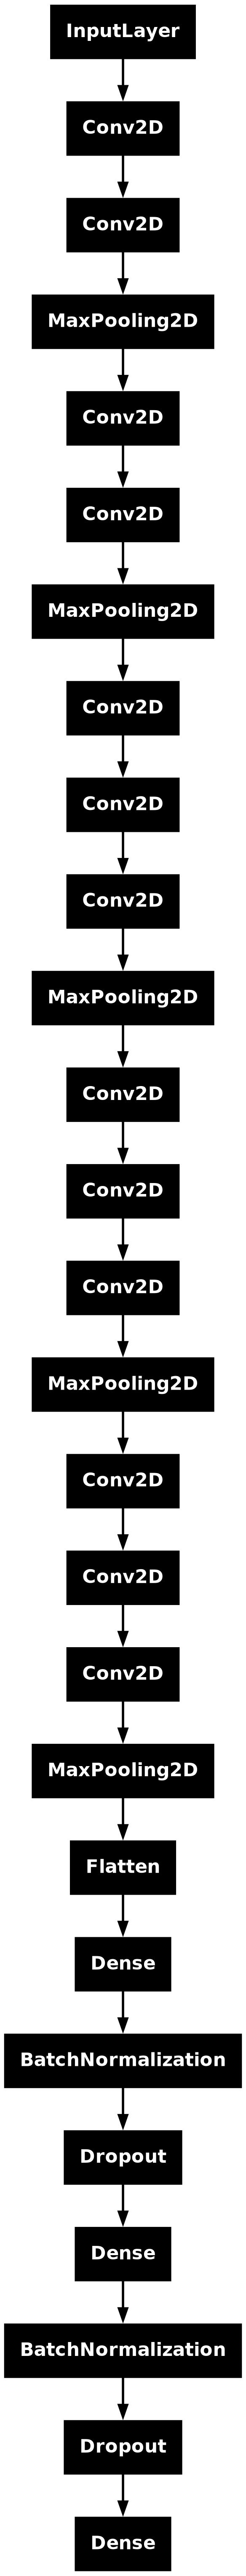

In [9]:
from tensorflow.keras.utils import plot_model

# Visualize the model architecture
plot_model(model,
#            show_shapes=True,
#            show_layer_names=True,
           to_file='model.png')

# Training

In [10]:
import tensorflow as tf
from keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
#     TensorBoard,
    ReduceLROnPlateau,
    CSVLogger,
    LearningRateScheduler,
    Callback
)
import datetime

# Define early stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=10)

# Define model checkpointing
model_checkpoint = ModelCheckpoint(
    "best_model.keras", monitor="val_loss", save_best_only=True
)

# Define TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1, update_freq="epoch"
)

# Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6)

# Define CSVLogger callback
csv_logger = tf.keras.callbacks.CSVLogger("training.log")


# Define LearningRateScheduler callback
def lr_scheduler(epoch, lr):
    if epoch % 10 == 0:
        return lr * 0.9
    else:
        return lr


lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

class EpochLogger(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"Starting epoch {epoch + 1}")
        self.current_epoch = epoch + 1

epoch_logger = EpochLogger()

# Combine all callbacks
callbacks = [
    early_stopping,
    model_checkpoint,
#     tensorboard_callback,
    reduce_lr,
    csv_logger,
    lr_scheduler_callback,
    epoch_logger
]

In [11]:
import time
import pandas as pd
from keras.optimizers import Adam, RMSprop, SGD, Adagrad, Adadelta, Nadam, AdamW

def define_optimizers():
    return {
        "Adam": Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, amsgrad=False),
#         "SGD": SGD(learning_rate=0.001, momentum=0.009, nesterov=False),
#         "Adagrad": Adagrad(learning_rate=0.001, epsilon=1e-7),
#         "Adadelta": Adadelta(learning_rate=0.001, rho=0.95, epsilon=1e-7),
#         "Nadam": Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
#         "RMSprop": RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-7),
#         "AdamW": AdamW(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-7, weight_decay=1e-2)
    }

def train_and_evaluate(model, train_generator, val_generator, test_generator, callbacks, batch_size):
    start_time = time.time()
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=callbacks,
        batch_size=batch_size,
        verbose=1,
    )
    training_time = (time.time() - start_time) / 60.0
    test_loss, test_accuracy = model.evaluate(test_generator, verbose=0)
    return history, training_time, test_loss, test_accuracy

def collect_metrics(history, training_time, test_loss, test_accuracy, model_name):
    return {
        'Model Name': model_name,
        'epoch': range(1, len(history.history['loss']) + 1),
        'train_loss': history.history['loss'],
        'train_accuracy': history.history['accuracy'],
        'val_loss': history.history['val_loss'],
        'val_accuracy': history.history['val_accuracy'],
        'training_time_minutes': [training_time] * len(history.history['loss']),
        'test_loss': [test_loss] * len(history.history['loss']),
        'test_accuracy': [test_accuracy] * len(history.history['loss'])
    }

def save_metrics(metrics, filename):
    pd.DataFrame(metrics).to_csv(filename, index=False)
    print(f"Metrics saved to {filename}")

def calculate_mean_metrics(metrics):
    return {
        'Model Name': metrics['Model Name'],
        'Optimizer': metrics['Optimizer'],
        'Mean_Train_Loss': np.mean(metrics['train_loss']),
        'Mean_Train_Accuracy': np.mean(metrics['train_accuracy']),
        'Mean_Val_Loss': np.mean(metrics['val_loss']),
        'Mean_Val_Accuracy': np.mean(metrics['val_accuracy']),
        'Total_Training_Time_Minutes': np.sum(metrics['training_time_minutes']),
        'Test_Loss': metrics['test_loss'][0],
        'Test_Accuracy': metrics['test_accuracy'][0]
    }

In [12]:
optimizers = define_optimizers()
summary_results = []
best_optimizer = None
best_val_accuracy = 0.0

for name, optimizer in optimizers.items():
    model = create_custom_model(model_name, num_layers_to_train, num_classes ,optimizer=optimizer)
    history, training_time, test_loss, test_accuracy = train_and_evaluate(
        model, train_generator, val_generator, test_generator, callbacks, batch_size=256
    )

    metrics = collect_metrics(history, training_time, test_loss, test_accuracy, model_name)
    metrics['Optimizer'] = name
    
    save_metrics(metrics, f"{name}_metrics_{model_name}.csv")
    
    mean_metrics = calculate_mean_metrics(metrics)
    summary_results.append(mean_metrics)

    if test_accuracy > best_val_accuracy:
        best_val_accuracy = test_accuracy
        best_optimizer = name

summary_df = pd.DataFrame(summary_results)
save_metrics(summary_df, f"summary_metrics_{model_name}.csv")

if best_optimizer:
    best_metrics_df = pd.read_csv(f"{best_optimizer}_metrics_{model_name}.csv")
    save_metrics(best_metrics_df, f"best_optimizer_metrics_{best_optimizer}_{model_name}.csv")

Starting epoch 1
Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1720964342.416308      96 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1720964342.448527      96 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.3070 - loss: 1.6035

W0000 00:00:1720964371.593539      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


200/200 ━━━━━━━━━━━━━━━━━━━━ 74s 154ms/step - accuracy: 0.3071 - loss: 1.6030 - val_accuracy: 0.2500 - val_loss: 7.9790 - learning_rate: 9.0000e-04
Starting epoch 2
Epoch 2/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 29s 140ms/step - accuracy: 0.3310 - loss: 1.4304 - val_accuracy: 0.2500 - val_loss: 8.3327 - learning_rate: 9.0000e-04
Starting epoch 3
Epoch 3/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 31s 151ms/step - accuracy: 0.3553 - loss: 1.3315 - val_accuracy: 0.2500 - val_loss: 4.5531 - learning_rate: 9.0000e-04
Starting epoch 4
Epoch 4/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 30s 147ms/step - accuracy: 0.4143 - loss: 1.2477 - val_accuracy: 0.2500 - val_loss: 2.6876 - learning_rate: 9.0000e-04
Starting epoch 5
Epoch 5/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 30s 144ms/step - accuracy: 0.4968 - loss: 1.0829 - val_accuracy: 0.4288 - val_loss: 1.5204 - learning_rate: 9.0000e-04
Starting epoch 6
Epoch 6/200
200/200 ━━━━━━━━━━━━━━━━━━━━ 30s 145ms/step - accuracy: 0.5659 - loss: 0.9380 - val_accuracy: 0.4900 - val_loss: 1.

In [13]:
summary_df

,Model Name,Optimizer,Mean_Train_Loss,Mean_Train_Accuracy,Mean_Val_Loss,Mean_Val_Accuracy,Total_Training_Time_Minutes,Test_Loss,Test_Accuracy
0,VGG16,Adam,0.510955,0.778486,1.030962,0.694023,1633.753223,0.38387,0.8425


In [14]:
display(summary_df)

summary_df.to_csv('hyperparameter.csv', index=False)


,Model Name,Optimizer,Mean_Train_Loss,Mean_Train_Accuracy,Mean_Val_Loss,Mean_Val_Accuracy,Total_Training_Time_Minutes,Test_Loss,Test_Accuracy
0,VGG16,Adam,0.510955,0.778486,1.030962,0.694023,1633.753223,0.38387,0.8425


In [15]:
best_metrics_df

,Model Name,epoch,train_loss,train_accuracy,val_loss,val_accuracy,training_time_minutes,test_loss,test_accuracy,Optimizer
0,VGG16,1,1.510443,0.320938,7.979049,0.25000,29.704604,0.38387,0.8425,Adam
1,VGG16,2,1.420313,0.333438,8.332675,0.25000,29.704604,0.38387,0.8425,Adam
2,VGG16,3,1.302149,0.374375,4.553054,0.25000,29.704604,0.38387,0.8425,Adam
3,VGG16,4,1.228630,0.430469,2.687624,0.25000,29.704604,0.38387,0.8425,Adam
4,VGG16,5,1.039900,0.525625,1.520444,0.42875,29.704604,0.38387,0.8425,Adam
5,VGG16,6,0.929365,0.571719,1.334579,0.49000,29.704604,0.38387,0.8425,Adam
6,VGG16,7,0.881801,0.585625,1.154592,0.49750,29.704604,0.38387,0.8425,Adam
7,VGG16,8,0.809569,0.617813,0.913613,0.58875,29.704604,0.38387,0.8425,Adam
8,VGG16,9,0.768468,0.636406,1.232546,0.43250,29.704604,0.38387,0.8425,Adam
9,VGG16,10,0.752438,0.643438,0.997231,0.53125,29.704604,0.38387,0.8425,Adam


# Evaluation

In [16]:
# evaluate model

from tensorflow.keras.models import load_model

model = load_model('./best_model.keras')
evaluation = model.evaluate(train_generator)
evaluation = model.evaluate(val_generator)
evaluation = model.evaluate(test_generator)

  2/200 ━━━━━━━━━━━━━━━━━━━━ 11s 57ms/step - accuracy: 0.9688 - loss: 0.1052

W0000 00:00:1720966096.679855      99 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


200/200 ━━━━━━━━━━━━━━━━━━━━ 27s 131ms/step - accuracy: 0.9174 - loss: 0.2145
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8621 - loss: 0.3578
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.8450 - loss: 0.3645


In [17]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder

def load_data(dataset_path):
    # Paths to train, val, and test directories
    train_path = os.path.join(dataset_path, 'train')
    val_path = os.path.join(dataset_path, 'val')
    test_path = os.path.join(dataset_path, 'test')

    # Function to load images from a directory
    def load_images_from_dir(dir_path, img_size=(128, 128)):  # Adjust size as needed
        images = []
        labels = []
        for class_name in os.listdir(dir_path):
            class_path = os.path.join(dir_path, class_name)
            if os.path.isdir(class_path):
                for img_name in os.listdir(class_path):
                    img_path = os.path.join(class_path, img_name)
                    img = load_img(img_path, target_size=img_size)
                    img_array = img_to_array(img)
                    images.append(img_array)
                    labels.append(class_name)
        return np.array(images), np.array(labels)

    # Load images and labels
    X_train, y_train = load_images_from_dir(train_path)
    X_val, y_val = load_images_from_dir(val_path)
    X_test, y_test = load_images_from_dir(test_path)

    # Normalize the images
    X_train = X_train / 255.0
    X_val = X_val / 255.0
    X_test = X_test / 255.0

    # Encode the labels
    le = LabelEncoder()
    y_train = le.fit_transform(y_train)
    y_val = le.transform(y_val)
    y_test = le.transform(y_test)

    # Save the label encoder for future use
    np.save('label_encoder_classes.npy', le.classes_)

    # Print some information
    print(f"Number of training samples: {len(X_train)}")
    print(f"Number of validation samples: {len(X_val)}")
    print(f"Number of testing samples: {len(X_test)}")
    print(f"Number of classes: {len(le.classes_)}")
    print(f"Class labels: {le.classes_}")

    return X_train, y_train, X_val, y_val, X_test, y_test,le.classes_

# Usage:
dataset_path = './Dataset'  # Replace with your actual path
X_train, y_train, X_val, y_val, X_test, y_test,classes = load_data(dataset_path)

Number of training samples: 6400
Number of validation samples: 800
Number of testing samples: 800
Number of classes: 4
Class labels: ['MildDemented' 'ModerateDemented' 'NonDemented' 'VeryMildDemented']


In [18]:
import numpy as np
import pandas as pd
import os
from time import time
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    cohen_kappa_score, log_loss, brier_score_loss,
    classification_report, confusion_matrix, roc_curve, auc,
    roc_auc_score
)
from sklearn.preprocessing import label_binarize

from keras.models import load_model
from keras.losses import categorical_crossentropy
from keras.utils import to_categorical

In [19]:
# Model Information
model_name = model_name 
num_layers = len(model.layers)
trainable_params = model.count_params()
non_trainable_params = sum([np.prod(v.shape) for v in model.non_trainable_weights])
activation_functions = 'Softmax'  # Typically used for multiclass



model_architecture = {
    'Model Name': model_name,
    'Number of Layers': num_layers,
    'Trainable Parameters': trainable_params,
    'Non-Trainable Parameters': non_trainable_params,
    'Activation Functions': activation_functions
}

df_architecture = pd.DataFrame([model_architecture])
df_architecture

,Model Name,Number of Layers,Trainable Parameters,Non-Trainable Parameters,Activation Functions
0,VGG16,27,15240468,160,Softmax


Training Config

In [20]:

optimizer = best_optimizer  # Assuming this is defined elsewhere
loss_function = 'Categorical Crossentropy'
time_taken_minutes = metrics['training_time_minutes'][-1]
final_epoch = best_metrics_df['epoch'].values[-1] 

# 2. Training Configuration
training_config = {
    'Optimizer': optimizer,
    'Loss Function': loss_function,
    'Final Epoch': final_epoch,
    'Training Time (minutes)': time_taken_minutes
}
df_training = pd.DataFrame([training_config])
df_training


,Optimizer,Loss Function,Final Epoch,Training Time (minutes)
0,Adam,Categorical Crossentropy,55,29.704604


Main Performance Metrics

In [21]:
num_classes = len(folders)
# Convert test labels to one-hot encoding
y_test_one_hot = to_categorical(y_test, num_classes)

# Evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test_one_hot, verbose=1)

# Make predictions
y_pred_probabilities = model.predict(X_test)
y_pred = np.argmax(y_pred_probabilities, axis=1)

# Get the number of classes
n_classes = y_pred_probabilities.shape[1]

# Compute metrics
accuracy = accuracy_score(y_test, y_pred)
precision_macro = precision_score(y_test, y_pred, average='macro')
recall_macro = recall_score(y_test, y_pred, average='macro')
f1_macro = f1_score(y_test, y_pred, average='macro')
precision_weighted = precision_score(y_test, y_pred, average='weighted')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
cohen_kappa = cohen_kappa_score(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision Macro: {precision_macro}")
print(f"Recall Macro: {recall_macro}")
print(f"F1 Macro: {f1_macro}")
print(" ")
print(f"Precision Weighted: {precision_weighted}")
print(f"Recall Weighted: {recall_weighted}")
print(f"F1 Weighted: {f1_weighted}")

print(f"Cohen Kappa: {cohen_kappa}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9104 - loss: 0.2239
 5/25 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step

W0000 00:00:1720966147.193859      98 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step
Accuracy: 0.8475
Precision Macro: 0.8454788745737022
Recall Macro: 0.8475000000000001
F1 Macro: 0.8462521092561872
 
Precision Weighted: 0.8454788745737022
Recall Weighted: 0.8475
F1 Weighted: 0.8462521092561873
Cohen Kappa: 0.7966666666666666


Probability based metrics

In [22]:
# Log loss (requires probabilities)
log_loss_value = log_loss(y_test, y_pred_probabilities)

# Brier score (requires binarized labels for multiclass)
y_test_bin = label_binarize(y_test, classes=range(n_classes))
brier_score = brier_score_loss(y_test_bin.ravel(), y_pred_probabilities.ravel())

# ROC AUC score (One-vs-Rest)
roc_auc_ovr = roc_auc_score(y_test_bin, y_pred_probabilities, multi_class='ovr', average='macro')


print(f"The Log Loss Value: {log_loss_value}")
print(f"Brier Score: {brier_score}")
print(f"ROC-AUC overall: {roc_auc_ovr}")

The Log Loss Value: 0.3726401345465791
Brier Score: 0.055447929074276384
ROC-AUC overall: 0.9631541666666666


Model Size and inference

In [23]:
# Model Size (MB)
model_size_mb = os.path.getsize('./best_model.keras') / (1024 * 1024)

# Inference Time (ms) - Average over 100 runs
inference_times = []
for _ in range(100):
    start = time()
    model.predict(X_test[:1])  # Predict on a single sample
    inference_times.append(time() - start)
inference_time_ms = np.mean(inference_times) * 1000

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━

Per class metrics and confusion matrix

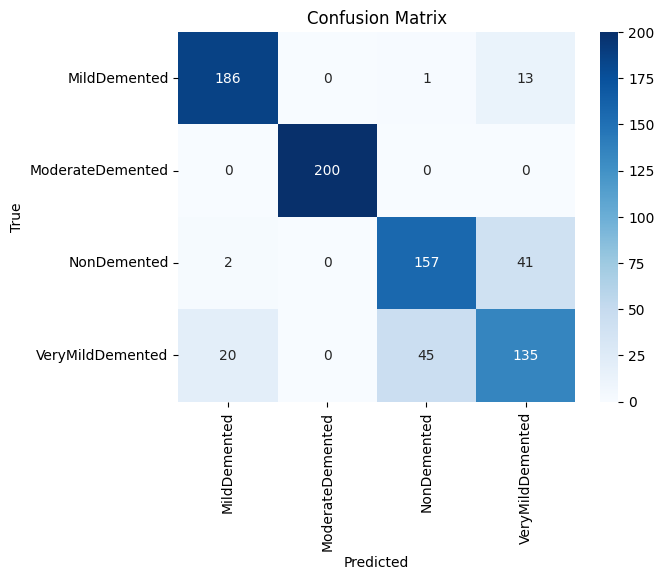

In [24]:
class_names = classes

# Per-Class Metrics
class_report = classification_report(y_test, y_pred, target_names=class_names, output_dict=True)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
# plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.savefig('multiclass_confusion_matrix.png')
plt.show()

In [25]:
performance_overview = {
    'Test Accuracy': test_acc,
    'Test Loss': test_loss,
    'Overall Accuracy': accuracy,
    'Cohen\'s Kappa': cohen_kappa,
    'Log Loss': log_loss_value,
    'Brier Score': brier_score
}

df_overview = pd.DataFrame([performance_overview])
df_overview

,Test Accuracy,Test Loss,Overall Accuracy,Cohen's Kappa,Log Loss,Brier Score
0,0.8475,0.37264,0.8475,0.796667,0.37264,0.055448


In [26]:
class_agnostic_metrics = {
    'Precision (Macro)': precision_macro,
    'Recall (Macro)': recall_macro,
    'F1-score (Macro)': f1_macro,
    'Precision (Weighted)': precision_weighted,
    'Recall (Weighted)': recall_weighted,
    'F1-score (Weighted)': f1_weighted,
    'ROC AUC (OvR, Macro)': roc_auc_ovr
}

df_class_agnostic = pd.DataFrame([class_agnostic_metrics])
df_class_agnostic

,Precision (Macro),Recall (Macro),F1-score (Macro),Precision (Weighted),Recall (Weighted),F1-score (Weighted),"ROC AUC (OvR, Macro)"
0,0.845479,0.8475,0.846252,0.845479,0.8475,0.846252,0.963154


In [27]:

# 5. Per-Class Metrics
per_class_metrics = {}
for i, class_name in enumerate(class_report.keys()):
    if class_name not in ['accuracy', 'macro avg', 'weighted avg']:
        class_dict = {
            f'Precision (Class {i})': class_report[class_name]['precision'],
            f'Recall (Class {i})': class_report[class_name]['recall'],
            f'F1-score (Class {i})': class_report[class_name]['f1-score'],
            f'Support (Class {i})': class_report[class_name]['support'],
            f'True Positives (Class {i})': conf_matrix[i, i]
        }
        per_class_metrics.update(class_dict)

df_per_class = pd.DataFrame([per_class_metrics])
df_per_class

,Precision (Class 0),Recall (Class 0),F1-score (Class 0),Support (Class 0),True Positives (Class 0),Precision (Class 1),Recall (Class 1),F1-score (Class 1),Support (Class 1),True Positives (Class 1),Precision (Class 2),Recall (Class 2),F1-score (Class 2),Support (Class 2),True Positives (Class 2),Precision (Class 3),Recall (Class 3),F1-score (Class 3),Support (Class 3),True Positives (Class 3)
0,0.894231,0.93,0.911765,200,186,1.0,1.0,1.0,200,200,0.773399,0.785,0.779156,200,157,0.714286,0.675,0.694087,200,135


In [28]:
# 6. Confusion Matrix Insights
confusion_matrix_insights = {}
for i in range(n_classes):
    for j in range(n_classes):
        if j != i:
            confusion_matrix_insights[f'Misclassified as Class {j} (from Class {i})'] = conf_matrix[i, j]

            

df_confusion = pd.DataFrame([confusion_matrix_insights])
df_confusion

,Misclassified as Class 1 (from Class 0),Misclassified as Class 2 (from Class 0),Misclassified as Class 3 (from Class 0),Misclassified as Class 0 (from Class 1),Misclassified as Class 2 (from Class 1),Misclassified as Class 3 (from Class 1),Misclassified as Class 0 (from Class 2),Misclassified as Class 1 (from Class 2),Misclassified as Class 3 (from Class 2),Misclassified as Class 0 (from Class 3),Misclassified as Class 1 (from Class 3),Misclassified as Class 2 (from Class 3)
0,0,1,13,0,0,0,2,0,41,20,0,45


In [29]:
deployment_metrics = {
    'Model Size (MB)': model_size_mb,
    'Inference Time (ms)': inference_time_ms
}

df_deployment = pd.DataFrame([deployment_metrics])
df_deployment

,Model Size (MB),Inference Time (ms)
0,174.526423,93.170192


In [30]:
# Assuming class names are based on the order of the folders
class_names = classes
n_classes = len(class_names)


avg_misclassification = {}
for i in range(n_classes):
    misclassified = sum(conf_matrix[i][j] for j in range(n_classes) if j != i)
    total = sum(conf_matrix[i])
    class_name = class_names[i]
    avg_misclassification[f'Avg Misclassification Rate ({class_name})'] = misclassified / total

df_misclassification = pd.DataFrame([avg_misclassification])
df_misclassification

,Avg Misclassification Rate (MildDemented),Avg Misclassification Rate (ModerateDemented),Avg Misclassification Rate (NonDemented),Avg Misclassification Rate (VeryMildDemented)
0,0.07,0.0,0.215,0.325


In [31]:

# Merge all DataFrames
final_df = pd.concat([
    df_architecture,
    df_training,
    df_overview,
    df_class_agnostic,
    df_per_class, 
#     df_confusion,
    df_deployment,
    df_misclassification
], axis=1)

# Save the final DataFrame to a CSV file
final_df.to_csv('segmented_multiclass_metrics.csv', index=False)

final_df

,Model Name,Number of Layers,Trainable Parameters,Non-Trainable Parameters,Activation Functions,Optimizer,Loss Function,Final Epoch,Training Time (minutes),Test Accuracy,...,Recall (Class 3),F1-score (Class 3),Support (Class 3),True Positives (Class 3),Model Size (MB),Inference Time (ms),Avg Misclassification Rate (MildDemented),Avg Misclassification Rate (ModerateDemented),Avg Misclassification Rate (NonDemented),Avg Misclassification Rate (VeryMildDemented)
0,VGG16,27,15240468,160,Softmax,Adam,Categorical Crossentropy,55,29.704604,0.8475,...,0.675,0.694087,200,135,174.526423,93.170192,0.07,0.0,0.215,0.325


Training Informations

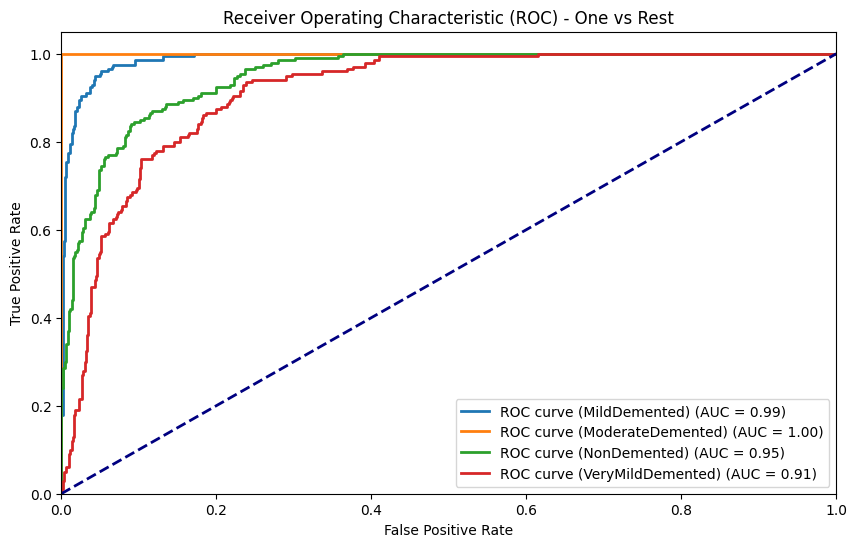

In [32]:
# Binarize the output
from sklearn.preprocessing import label_binarize
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3])

# Visualization 2: ROC Curves (One-vs-Rest)
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probabilities[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve ({class_names[i]}) (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - One vs Rest')
plt.legend(loc="lower right")
plt.savefig('multiclass_roc_curves.png')
plt.show()

In [33]:

# Optional: Save model summary and training history
model.summary(print_fn=lambda x: open('model_summary.txt', 'a').write(x + '\n'))

# Assuming you have training history
history_df = pd.DataFrame(history.history)
history_df.to_csv('training_history.csv', index=False)
history_df

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.320938,1.510443,0.25000,7.979049,9.000000e-04
1,0.333438,1.420313,0.25000,8.332675,9.000000e-04
2,0.374375,1.302149,0.25000,4.553054,9.000000e-04
3,0.430469,1.228630,0.25000,2.687624,9.000000e-04
4,0.525625,1.039900,0.42875,1.520444,9.000000e-04
5,0.571719,0.929365,0.49000,1.334579,9.000000e-04
6,0.585625,0.881801,0.49750,1.154592,9.000000e-04
7,0.617813,0.809569,0.58875,0.913613,9.000000e-04
8,0.636406,0.768468,0.43250,1.232546,9.000000e-04
9,0.643438,0.752438,0.53125,0.997231,9.000000e-04


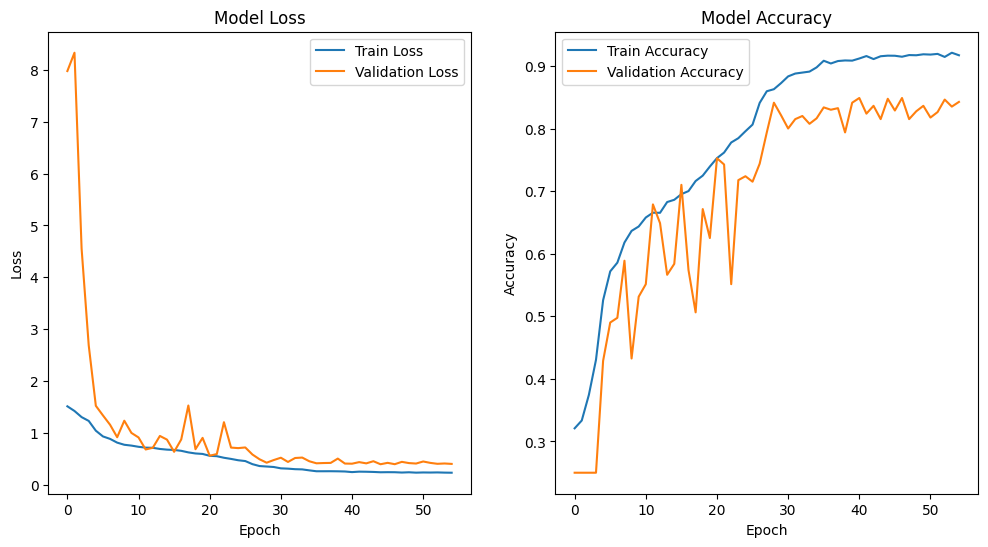

In [34]:

# Plot training history
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

In [35]:
import os
import shutil
import zipfile

# Define the directory containing the files
source_directory = '/kaggle/working/'

# List of file extensions to include
file_extensions = ['.png', '.csv', '.txt','.keras']

# Create a new directory for the selected files
selected_directory = '/kaggle/working/SelectedFiles/'
os.makedirs(selected_directory, exist_ok=True)

# Move the selected files into the new directory
for foldername, subfolders, filenames in os.walk(source_directory):
    for filename in filenames:
        if any(filename.endswith(ext) for ext in file_extensions):
            source_path = os.path.join(foldername, filename)
            destination_path = os.path.join(selected_directory, filename)
            shutil.move(source_path, destination_path)

# Create a ZipFile object
zip_filename = f"{model_name}.zip"
with zipfile.ZipFile(zip_filename, 'w') as zipf:
    # Add the selected directory and its contents to the zip file
    for foldername, _, filenames in os.walk(selected_directory):
        for filename in filenames:
            file_path = os.path.join(foldername, filename)
            zipf.write(file_path, os.path.relpath(file_path, selected_directory))

print(f'{zip_filename} created successfully.')

VGG16.zip created successfully.
